In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
imagenet_pretrained_path = "./features/ImageNet_pretrained/"
imagenet_C_path = "./features/ImageNetC/"
imagenet_models = ["ViT_L_16"]

dfs = []
for model_name in imagenet_models:
    df_test = pd.read_pickle("{}/{}/test.pickle".format(imagenet_pretrained_path, model_name))
    df_test['predicted_label'] = df_test['classifier'].apply(lambda x: np.argmax(x))
    df_test['model'] = "BASIC_" + model_name
    df_test = df_test[['model', 'original_label', 'predicted_label']]
    dfs.append(df_test)

for model_name in imagenet_models:
    pickle_files = [f for f in os.listdir(imagenet_C_path+"/"+model_name) if f.endswith('.pickle')]
    for pickle_file in pickle_files:
        df = pd.read_pickle("{}/{}/{}".format(imagenet_C_path, model_name, pickle_file)).reset_index(drop=True)
        df['predicted_label'] = df['classifier'].apply(lambda x: np.argmax(x))
        df['model'] = "C_" + "_".join(model_name.split("_")[-2:]) + pickle_file.split(".")[0].replace("ImageNetC", "")
        df = df[['model', 'original_label', 'predicted_label']]
        dfs.append(df)

df = pd.concat(dfs)

In [3]:
df['accuracy'] = (df['original_label'] == df['predicted_label']).astype(int)
agg_df = df.pivot_table(columns='model', values='accuracy', aggfunc='mean').reset_index()
agg_df

model,index,BASIC_ViT_L_16,C_L_16_brightness_1,C_L_16_brightness_2,C_L_16_brightness_3,C_L_16_brightness_4,C_L_16_brightness_5,C_L_16_contrast_1,C_L_16_contrast_2,C_L_16_contrast_3,...,C_L_16_speckle_noise_1,C_L_16_speckle_noise_2,C_L_16_speckle_noise_3,C_L_16_speckle_noise_4,C_L_16_speckle_noise_5,C_L_16_zoom_blur_1,C_L_16_zoom_blur_2,C_L_16_zoom_blur_3,C_L_16_zoom_blur_4,C_L_16_zoom_blur_5
0,accuracy,0.79672,0.7723,0.76192,0.7441,0.71992,0.68174,0.74852,0.7365,0.71138,...,0.7406,0.71986,0.63172,0.55958,0.45526,0.6286,0.554,0.48678,0.42424,0.35254


In [4]:
with open("./imagenet_classes_name.dat", 'r') as file:
    file_content = file.read()
    imagenet_classes = eval(file_content)

In [5]:
mean_accuracy_per_class = df.groupby(['model', 'original_label'])['accuracy'].mean().reset_index()

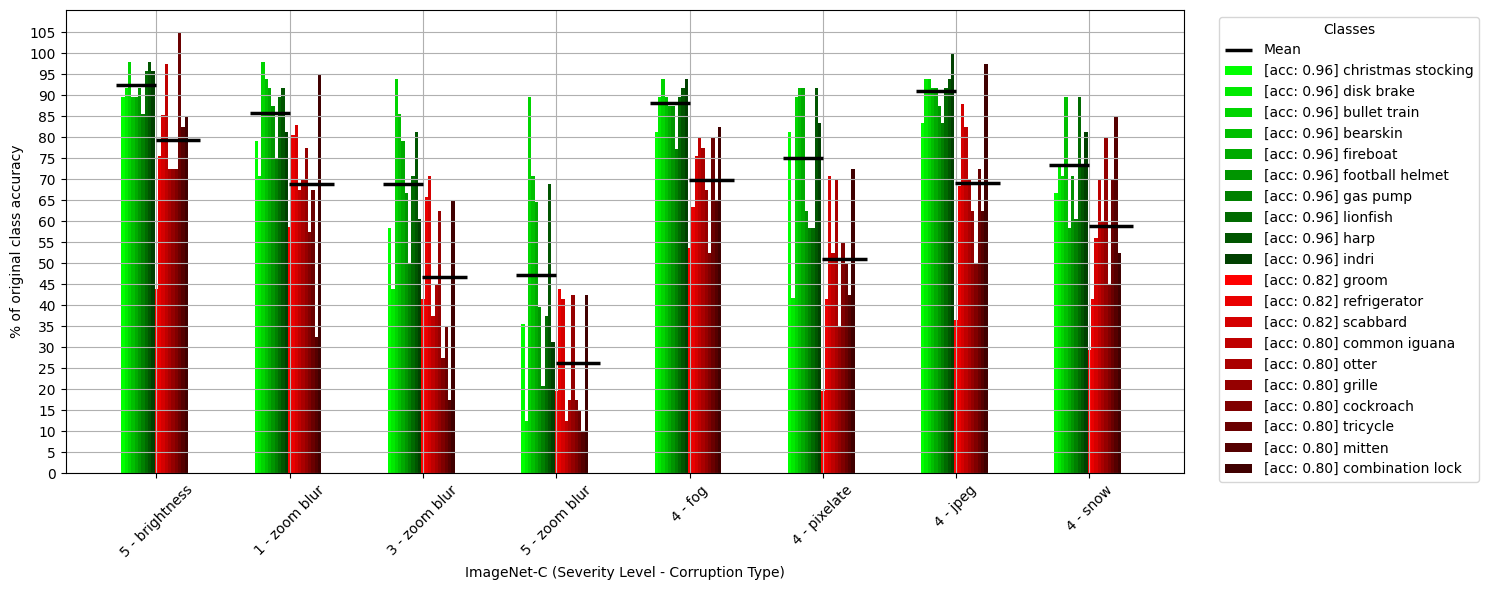

In [10]:
df = mean_accuracy_per_class

base_models = df[df['model'].str.contains("BASIC_")]
sorted_base_models = base_models.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

selected_classes_ok = sorted_base_models.iloc[range(1000)[100:110]]['original_label'].unique()
selected_classes_bad = sorted_base_models.iloc[range(1000)[550:560]]['original_label'].unique()

selected_classes = []
selected_classes.extend(selected_classes_ok)
selected_classes.extend(selected_classes_bad)

random_c_model_names = ["C_L_16_brightness_5", "C_L_16_zoom_blur_1", "C_L_16_zoom_blur_3", "C_L_16_zoom_blur_5", "C_L_16_fog_4", "C_L_16_pixelate_4", "C_L_16_jpeg_compression_4", "C_L_16_snow_4"]
random_c_models = df[df['model'].isin(random_c_model_names)]

merged_data = pd.DataFrame()
for c_model_name in random_c_model_names:
    c_model_data = random_c_models[random_c_models['model'] == c_model_name]
    merged = pd.merge(sorted_base_models, c_model_data, on='original_label', suffixes=('_base', '_c'))
    merged = merged[merged['original_label'].isin(selected_classes)]
    merged['c_model_name'] = c_model_name
    merged_data = pd.concat([merged_data, merged])

plt.figure(figsize=(15, 6))

bar_width = 0.025
index = np.arange(len(random_c_model_names))

greens = ["#00ff00", "#00ea00", "#00d500", "#00bf00", "#00aa00", "#009500", "#008000", "#006a00", "#005500", "#004000"]
reds = ["#ff0000", "#ea0000", "#d50000", "#bf0000", "#aa0000", "#950000", "#800000", "#6a0000", "#550000", "#400000"]
colors = greens + reds

total_accuracies_green = np.zeros(len(random_c_model_names))
total_accuracies_red = np.zeros(len(random_c_model_names))
count_green = np.zeros(len(random_c_model_names))
count_red = np.zeros(len(random_c_model_names))

for i, label in enumerate(selected_classes):
    is_green = label in selected_classes_ok
    for j, c_model_name in enumerate(random_c_model_names):
        class_data = merged_data[merged_data['original_label'] == label]
        model_data_c = class_data[class_data['c_model_name'] == c_model_name]
        model_data_base = sorted_base_models[sorted_base_models['original_label'] == label]

        accuracy_c = model_data_c['accuracy_c'].mean() if not model_data_c.empty else 0
        accuracy_base = model_data_base['accuracy'].mean() if not model_data_base.empty else 0

        percent_accuracy_c = (accuracy_c / accuracy_base * 100) if accuracy_base != 0 else 0
        _label = "[acc: {:0.2f}] {}".format(accuracy_base, imagenet_classes[label].split(",")[0].lower())
        
        plt.bar(index[j] + i * bar_width, percent_accuracy_c, bar_width, label=_label, color=colors[i % len(colors)])

        if is_green:
            total_accuracies_green[j] += percent_accuracy_c
            count_green[j] += 1
        else:
            total_accuracies_red[j] += percent_accuracy_c
            count_red[j] += 1

mean_accuracies_green = total_accuracies_green / count_green
mean_accuracies_red = total_accuracies_red / count_red

line_width, line_length = 2.5, 0.1
for j in range(len(random_c_model_names)):
    plt.hlines(mean_accuracies_green[j], 0.25 + line_length + index[j] - line_length, -0.15 + index[j] + line_length, colors="#000000", linewidth=line_width, label='Mean')
    plt.hlines(mean_accuracies_red[j], -1.3*line_length + index[j] + bar_width * (len(selected_classes) - 1) - line_length, index[j] + bar_width * (len(selected_classes) - 0.8) + line_length, colors='#000000', linewidth=line_width, label='Mean')
    
plt.xlabel('ImageNet-C (Severity Level - Corruption Type)')
plt.ylabel('% of original class accuracy')
plt.title('')

random_c_model_names = ["5 - brightness", "1 - zoom blur", "3 - zoom blur", "5 - zoom blur", "4 - fog", "4 - pixelate", "4 - jpeg", "4 - snow"]
plt.xticks(index + bar_width * len(selected_classes) / 2, random_c_model_names, rotation=45)
plt.yticks([5*i for i in range(22)])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Classes', bbox_to_anchor=(1.025, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()